# Using MELD to characterize chordin loss-of-function
## Introduction

In this tutorial, we will demonstrate how to use MELD to characterize the effect of Cas9-mutagenesis in the zebrafish embryo. We will use a dataset generated by the Klein and Megason labs and published in [Wagner et al. (2018) (doi: 10.1126/science.aar4362)](https://www.ncbi.nlm.nih.gov/pubmed/29700229). Here, zebrafish embryos were injected with Cas9 + gRNAs at the one-cell stage targeting either chordin (*chd*) in the experimental condition or tyrosinase (*tyr*) in the control condition. Embryos were collected in a rough time course from 14-16 hours post fertilization for scRNA-seq and 27,000 cells were recovered.

[Chordin](https://www.genecards.org/cgi-bin/carddisp.pl?gene=CHRD) is a BMP antagonist required for proper specification of dorsally-derived neural tissues ([Hammerschmidt et al. 1997](https://www.ncbi.nlm.nih.gov/pubmed/9007232)). [Tyrosinase](https://www.genecards.org/cgi-bin/carddisp.pl?gene=TYR) is a gene required for melanin production, but does not affect cell type specification at the time points considered in this study.

We will also introduce some basics of preprocessing, visualization and imputation to give an idea of how you might include MELD in a general scRNA-seq analysis workflow.

**Note:** this is a modified and abbreviated version of the original notebook available on [the MELD GitHub](https://github.com/KrishnaswamyLab/MELD). The full version includes parameter optimization and VFC on subclusters.

Here's the order we'll follow:

* [1. Loading the dataset](#1.-Loading-data)  
* [2. Embedding Data Using PHATE](#3.-Embedding-Data-Using-PHATE)
* [3. Using MELD to calculate sample-associated density estimates and likelihood](#4.-Using-MELD-to-calculate-sample-associated-density-estimates-and-relative-likelihood)

## 0. Installing packages

If you haven't installed MELD yet, you can do so from this notebook. We'll also install some other useful packages while we're at it.

In [3]:
!pip install --user meld phate magic-impute cmocean diffxpy seaborn

## 1. Loading data

**Standard imports**


In [4]:
import pandas as pd
import numpy as np
import graphtools as gt
import phate
import magic
import scprep
import meld
import cmocean
import sklearn
import scipy
import seaborn as sns

# setting defaults for matplotlib font sizes
import matplotlib.pyplot as plt
plt.rc('font', size=14)

# making sure plots & clusters are reproducible
np.random.seed(42)

%load_ext autoreload
%autoreload 2

import diffxpy.api as de

/home/dan/.local/lib/python3.8/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [5]:
np.random.seed(0)

## Load data

To facilitate running this notebook quickly, we're going to download a preprocessed AnnData object from FigShare.

The preprocessing steps to download the published data from GEO and perform filtering, library size normalization, and sqrt transformation can be found in the full tutorial on [the MELD GitHub](https://github.com/KrishnaswamyLab/MELD).

In [6]:
URL = "https://ndownloader.figshare.com/files/25687247?private_link=f194ae7d6bcec9bd11a3"

with tempfile.TemporaryDirectory() as tempdir:
        filepath = os.path.join(tempdir, "Klein2018_Zebrafish.h5ad")
        scprep.io.download.download_url(URL, filepath)
        adata = sc.read_h5ad(filepath)

### Subsample

To enable this dataset to run in Google CoLab, we need to subsample to 10,000 cells.



In [89]:
subsample_index = np.random.choice(adata.shape[0], size=10000, replace=False)
adata = adata[subsample_index].copy()

In [92]:
data = adata.to_df()
metadata = adata.obs

### Examining the number of cells in each sample past filtering



First, we create a colormap for visualizating the samples. You can select colors by hex code with Google's [RGB color picker](https://www.google.com/search?client=firefox-b-1-d&q=rgb+color+picker).

In [95]:
sample_cmap = {'chdA' : '#fb6a4a',
                'chdB' : '#de2d26',
                'chdC' : '#a50f15',
                'tyrA' : '#6baed6',
                'tyrB' : '#3182bd',
                'tyrC' : '#08519c'}

As we can see in the following plot, there are many more cells that passed QC in the chdA condition relative to the other samples. To account for this, the MELD algorithm automatically normalizes each replicate to account for varying numbers of cells.



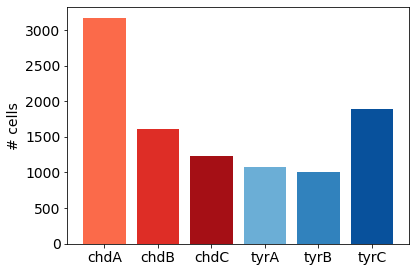

In [96]:
fig, ax = plt.subplots(1)

groups, counts = np.unique(metadata['sample_labels'], return_counts=True)
for i, c in enumerate(counts):
    ax.bar(i, c, color=sample_cmap[groups[i]])
    
ax.set_xticks(np.arange(i+1))
ax.set_xticklabels(groups)
ax.set_ylabel('# cells')

fig.tight_layout()

## 2. Embedding Data Using PHATE

The API of PHATE models that of Scikit Learn. First, you instantiate a PHATE estimator object with the parameters for fitting the PHATE embedding to a given dataset. Next, you use the `fit` and `fit_transform` functions to generate an embedding. For more information, check out [**the PHATE readthedocs page**](http://phate.readthedocs.io/).

We'll just use the default parameters for now, but the following parameters can be tuned (read our documentation at [phate.readthedocs.io](https://phate.readthedocs.io/) to learn more):

* `knn` : Number of nearest neighbors (default: 5). Increase this (e.g. to 20) if your PHATE embedding appears very disconnected. You should also consider increasing `knn` if your dataset is extremely large (e.g. >100k cells)
* `decay` : Alpha decay (default: 15). Decreasing `decay` increases connectivity on the graph, increasing `decay` decreases connectivity. This rarely needs to be tuned. Set it to `None` for a k-nearest neighbors kernel.
* `t` : Number of times to power the operator (default: 'auto'). This is equivalent to the amount of smoothing done to the data. It is chosen automatically by default, but you can increase it if your embedding lacks structure, or decrease it if the structure looks too compact.
* `gamma` : Informational distance constant (default: 1). `gamma=1` gives the PHATE log potential, but other informational distances can be interesting. If most of the points seem concentrated in one section of the plot, you can try `gamma=0`.


Here's the simplest way to apply PHATE:
```python
phateop = phate.PHATE(knn=9, decay=10, gamma=0, n_jobs=-2)
Y = phateop.fit_transform(data_sqrt)
```

In [100]:
phate_op = phate.PHATE(n_jobs=-1)
data_phate = phate_op.fit_transform(data_pca)

Calculating PHATE...
  Running PHATE on 10000 cells and 100 genes.
  Calculating graph and diffusion operator...
    Calculating KNN search...
    Calculated KNN search in 4.66 seconds.
    Calculating affinities...
    Calculated affinities in 0.39 seconds.
  Calculated graph and diffusion operator in 5.08 seconds.
  Calculating landmark operator...
    Calculating SVD...
    Calculated SVD in 1.05 seconds.
    Calculating KMeans...
    Calculated KMeans in 17.29 seconds.
  Calculated landmark operator in 19.87 seconds.
  Calculating optimal t...
  Calculated optimal t in 1.35 seconds.
  Calculating diffusion potential...
  Calculated diffusion potential in 0.50 seconds.
  Calculating metric MDS...
  Calculated metric MDS in 5.23 seconds.
Calculated PHATE in 32.05 seconds.


### Coloring a PHATE plot by sample ID

And then we plot using `scprep.plot.scatter2d`. For more advanced plotting, we recommend Matplotlib. If you want more help on using Matplotlib, they have [**extensive documentation**](https://matplotlib.org/tutorials/index.html) and [**many Stackoverflow threads**](https://stackoverflow.com/questions/tagged/matplotlib).

<AxesSubplot:xlabel='PHATE1', ylabel='PHATE2'>

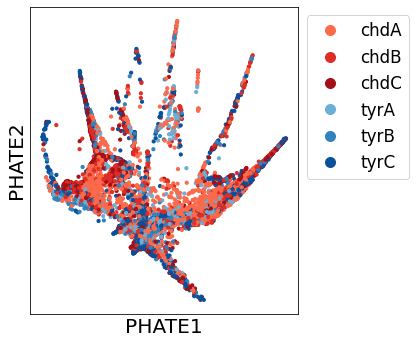

In [101]:
scprep.plot.scatter2d(data_phate, c=metadata['sample_labels'], cmap=sample_cmap, 
                      legend_anchor=(1,1), figsize=(6,5), s=10, label_prefix='PHATE', ticks=False)

### Coloring a PHATE plot by ClusterIDs

In Wagner et al. (2018), cells from the *chd* and *tyr* conditions were assigned cluster IDs through projection back to a reference dataset. In the published analysis, these number of cells mapping to each cluster in the *chd* vs *tyr* condition was used at the measure of *chd* loss-of-function on that cluster. To visualize the relationships between these clusters, we will color the PHATE plot by each cell's published ClusterID.

/home/dan/.local/lib/python3.8/site-packages/scprep/plot/utils.py:97: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
  fig.tight_layout()


<AxesSubplot:xlabel='PHATE1', ylabel='PHATE2'>

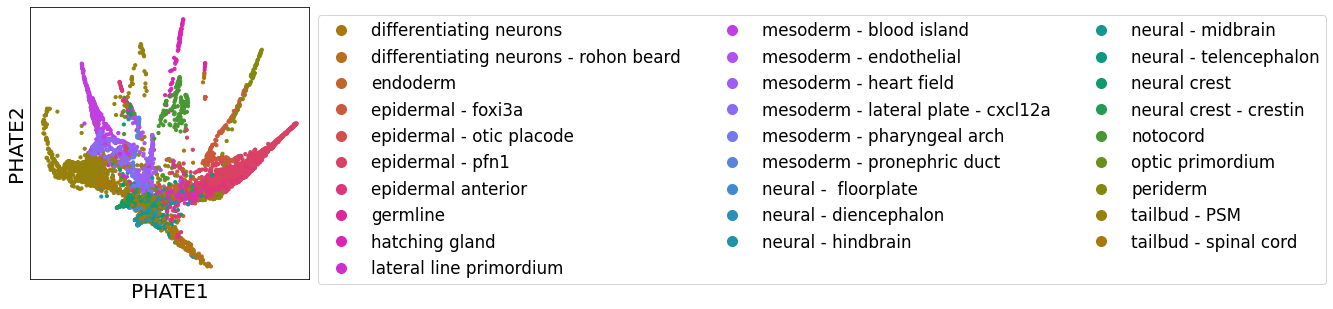

In [102]:
scprep.plot.scatter2d(data_phate, c=metadata['cluster'], cmap=cmocean.cm.phase, 
                      legend_anchor=(1,1), figsize=(5,5), s=10, label_prefix='PHATE', ticks=False)

### Discussion Question

1. What do you notice about this PHATE plot when you compare to the distribution of sample labels above? Are there some clusters that you think are more or less suited to analysis of differential abundnace?
  - Answer: Examining this PHATE plot, we see observe a complex many-branched structure. We can see that each region or branch of the PHATE plot is enriched for various clusters. However, you may notice that there are some clusters that occupy several branches of the plot. This is one of the issues with clustering - it is not perfect and the diversity within each cluster may not be uniform across clusters.

## 4. Using MELD to calculate sample-associated density estimates and relative likelihood

Using MELD, we quantify the effect of an experimental perturbation by first estimating the density of each sample over a graph learned from all cells from all samples. This yields one density estimate per sample. We then normalize density estimates across samples from the same replicate to calculate the sample-associated relative likelihood. This relative likelihood is a ratio between the sample probability densities from each condition and indicates how much more likely we are to observe a given cell in one condition relative to another. 

We can use the relative likelihood estimates to identify which cells are the most enriched in each experimental condition and which cell types are unchanging across conditions. We can also use this value to identify the gene signature of a perturbation (*i.e.* the genes that change the most across experimental conditions).

#### Separating replicate and conditions

We run the MELD algorithm on each sample independently, then normalize within each replicate. First we're going to create a vector that indicated the replicate that each cell was sequenced in.

In [35]:
metadata['genotype'] = [1 if sl.startswith('chd') else 0 for sl in metadata['sample_labels']]
metadata['genotype_name'] = ['chd' if g == 1 else 'tyr' for g in metadata['genotype']]
metadata['replicate'] = [sl[-1] for sl in metadata['sample_labels']]

### Run MELD

These next two code blocks build the graph for MELD and estimate the density of each sample. The parameters for knn and beta are optimized in the [full notebook on GitHub](https://github.com/KrishnaswamyLab/MELD).

Here, we're going to create a MELD operator object, which inherits from the sklearn [`BaseEstimator`](https://scikit-learn.org/stable/modules/generated/sklearn.base.BaseEstimator.html). The full documentation for MELD can be found here: https://meld-docs.readthedocs.io/en/stable/

The input to MELD is the data and the sample labels. Here, we're only using the first 100 PCs of the data. The output of `meld_op.fit_transform()` is the sample associated density estimate referenced in the [MELD paper](https://www.biorxiv.org/content/10.1101/532846v4). This is equivalent to a kernel density estimate of the sample over the graph.

In [36]:
# beta is the amount of smoothing to do for density estimation
# knn is the number of neighbors used to set the kernel bandwidth
meld_op = meld.MELD(beta=67, knn=7)
sample_densities = meld_op.fit_transform(data_pca, sample_labels=metadata['sample_labels'])

Building graph on 26827 samples and 100 features.
Calculating graph and diffusion operator...
  Calculating KNN search...
  Calculated KNN search in 73.50 seconds.
  Calculating affinities...
  Calculated affinities in 2.75 seconds.
Calculated graph and diffusion operator in 78.60 seconds.


Let's look at the sample densities on a PHATE plot.



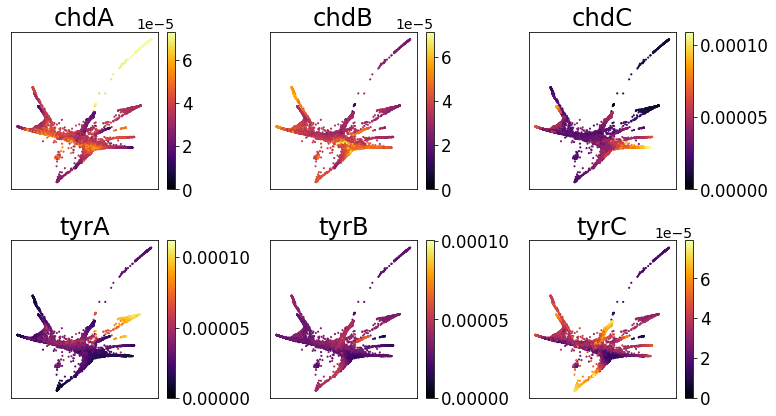

In [53]:
fig, axes = plt.subplots(2,3, figsize=(11,6))

for i, ax in enumerate(axes.flatten()):
    density = sample_densities.iloc[:,i]
    scprep.plot.scatter2d(data_phate, c=density,
                          title=density.name,
                          vmin=0, 
                          ticks=False, ax=ax)
    
fig.tight_layout()

### Discussion question

1. What is the sum of the density of each sample over the data? How would you calculate this?
 - Answer: The density of each sample sums to 1. You can confirm this by running `sample_densities.sum(axis=0)`.
2. What do you notice about the density of each sample across replicates? Do you see more similarity between samples of the same replicate or of the same condition?
  - Answer: Based on these plots, it's hard to tell. There are some similarities across the C replicates. This could be quantified by calculating the optimal transport distance between the samples, but this is beyond the scope of the workshop notebook.

Once we have the densities, we then compare the densities between conditions within each replicate. This gives us a relative likleihood that a given cell would be observed in each condition. 

In common speach, likelihood and probability are used interchangably. However they have very distinct statistical meanings. The probability (or probability density) of an event is the chance that an event will happen under a given model. In this case, the sample densities are the probability that if you were to randomly pick a new cell from that sample that it would be a given cell. However, when comparing the densities for each sample for a specific cell, these values can be considered the likelihood that the cell would be observed in a given sample. 

We want to calculate the ratio between these likelihoods so that we can understand how much more likely it would be to observe a cell in the treatment condition relative to the control condition. To calculate this ratio, we apply an L1 normalization of the densities within each replicate. This normalizes the values to sum to 1 across samples within each replicte. 

In [54]:
# This is a helper function to apply L1 normalization across the densities for each replicate
def replicate_normalize_densities(sample_densities, replicate):
    # Get the unique replicates
    replicates = np.unique(replicate)
    sample_likelihoods = sample_densities.copy()
    for rep in replicates:
        # Select the columns of `sample_densities` for that replicate
        curr_cols = sample_densities.columns[[col.endswith(rep) for col in sample_densities.columns]]
        curr_densities = sample_densities[curr_cols]
        # Apply L1 normalization
        sample_likelihoods[curr_cols] = sklearn.preprocessing.normalize(curr_densities, norm='l1')
    return sample_likelihoods

In [55]:
sample_likelihoods = replicate_normalize_densities(sample_densities, metadata['replicate'])

We now have the sample associated relative likelihoods for each condition.

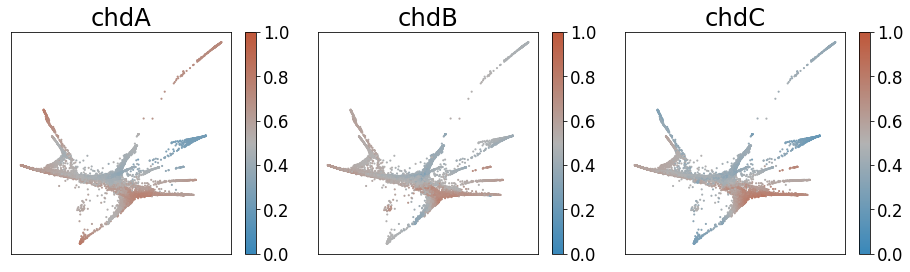

In [56]:
fig, axes = plt.subplots(1,3, figsize=(13,4))

experimental_samples = ['chdA', 'chdB', 'chdC']

for i, ax in enumerate(axes):
    curr_sample = experimental_samples[i]
    scprep.plot.scatter2d(data_phate, c=sample_likelihoods[curr_sample], cmap=meld.get_meld_cmap(),
                          vmin=0, vmax=1,
                          title=curr_sample, ticks=False, ax=ax)

fig.tight_layout()

We can also look at the mean and standard deviation of the relative likelihood estimates across replicates. Notice how areas that are consistently enriched or depleted across replicates have low standard deviation.

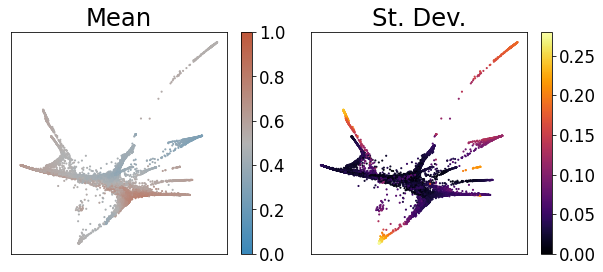

In [57]:
fig, axes = plt.subplots(1,2, figsize=(8.7,4))

scprep.plot.scatter2d(data_phate, c=sample_likelihoods[experimental_samples].mean(axis=1), 
                      cmap=meld.get_meld_cmap(), vmin=0, vmax=1,
                      title='Mean', ticks=False, ax=axes[0])
scprep.plot.scatter2d(data_phate, c=sample_likelihoods[experimental_samples].std(axis=1), vmin=0, 
                      cmap='inferno', title='St. Dev.', ticks=False, ax=axes[1])

fig.tight_layout()

We use the average likelihood of the chordin samples as the measure of the perturbation.

In [58]:
metadata['chd_likelihood'] = sample_likelihoods[experimental_samples].mean(axis=1).values

### Discussion Questions:
1. Here, we only look at the `chd` relative likelihood. Why don't we look at the `tyr` relative likelihood?
  - Answer: The tyr relative likelihood is simply 1 - chd_likelihood, so it's not informative for datasets with 2 samples. In this context, we're interested in how enriched or depleted a cell is in the treatment condition relative to the control. 
2. What does the variation in the relative likelihood values across replicates tell you?
  - Answer: The variation identified regions of cells that have consitent or inconsistent responses to perturbations across replicates. If the variation is high, it suggests that those cells exhibit differing responses across replicates. This might suggest that the results in those cells should be treated with more skepticism.

### Examining the distribution of _chd_ likelihood values in published clusters

Finally, we will compare using clusters based on data geometry to using MELD for quantifying the effect of an experimental perturbation. 

In [59]:
sample_cmap = {'chdA': '#fb6a4a',
                 'chdB': '#de2d26',
                 'chdC': '#a50f15',
                 'tyrA': '#6baed6',
                 'tyrB': '#3182bd',
                 'tyrC': '#08519c'}


Let's sort the index of each cluster from lowest to highest average _chd_ likelihood value

In [60]:
metadata['clusterID'] = scprep.utils.sort_clusters_by_values(metadata['clusterID'], metadata['chd_likelihood'])

#### Create jitter plots

These show the distribution of _chd_ likelihood values within each cluster. Each point is a cell and the y-axis is the _chd_ likelihood. The slight jitter in the x-xais is  only to help show density within each cluster.

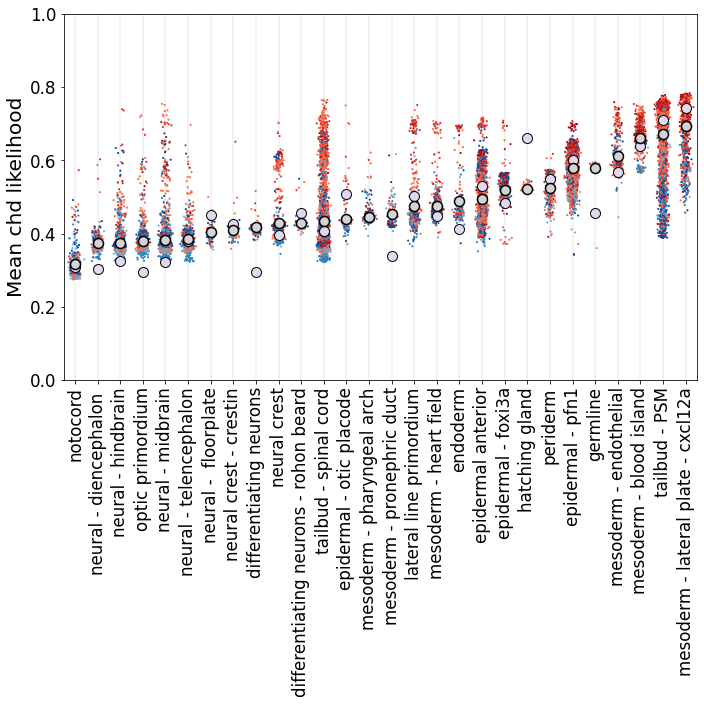

In [61]:
fig, ax = plt.subplots(1, figsize=(10,10))

# See example usage: https://scprep.readthedocs.io/en/stable/examples/jitter.html
scprep.plot.jitter(metadata['clusterID'], metadata['chd_likelihood'], c=metadata['sample_labels'], 
                   cmap=sample_cmap,legend=False, plot_means=True, xlabel=False, ylabel='Mean chd likelihood',
                   ax=ax)

### This code will plot the ratio of tyr:chd cells per cluster
means = metadata.groupby('clusterID')['genotype'].mean()
ax.scatter(means.index, means - np.mean(metadata['genotype']) + 0.5, color='#e0d8f0', edgecolor='k', s=100)

# Axis tick labels
ax.set_xticklabels(metadata.set_index('clusterID')['cluster'].drop_duplicates().sort_index(), rotation=90)
ax.set_ylim(0,1)

fig.tight_layout()

### Discussion

1. What do you notice about the distribution of relative likelihood values within each cluster? Are there clusters where the fold-change in abundance (purple circles) and average likelihood (grey cirlces) differ greatly? Why do you think that is?
- Answer: Here, we can see the distribution of _chd_ likelihood values for each cell organized by the clusterID assigned by Wagner et al. (2018). Due to the issues with clustering above, we see that some clusters contain "outliers." For example, in the cluster on the far left, "optic primordium", has an average _chd_ likelihood value of around -0.28, indicating that these cells are generally more prototypical in the tyrosinase condition. This is consisten with the observed reduced head size in *chd* mutant zebrafish (See Wanger et al. 2018 for a thorough description of the mutant phenotype). However, there are also some cells with very high _chd_ likelihood values, and a couple with values around 0.55. This is a result of the clustering assigning the same cluster label to cells that are not adjacent on the cell similarity graph. This problem is especially apparent with the `tailbud - spinal cord` and `tailbud - PSM`* populations where the range of _chd_ likelihood values in each group is especially large. In the MELD publication, we focued on the tailbud - presomitic mesoderm population. So let's start there.

\*(PSM = presomitic mesoderm)

### Activity

Here, we want to visualize the heterogeneity within some clusters using PHATE run on each subset of the data.

Pick one cluster above with a large amount of variation and one cluster with a low amount of variation. Coordinate with your group to try to get a number of different clusters chosen per group.

Use the code below to plot the PHATE embedding of that cluster and color it by the likelihood values. What do you notice about the relationship between standard deviation of the likelihood and the amount of heterogenity seen in the PHATE embedding? What does this suggest?

In [63]:
# These are the cluster names
print(metadata['cluster'].unique())

['hatching gland' 'differentiating neurons - rohon beard' 'tailbud - PSM'
 'epidermal anterior' 'periderm' 'neural - midbrain'
 'mesoderm - lateral plate - cxcl12a' 'neural crest'
 'mesoderm - blood island' 'tailbud - spinal cord' 'epidermal - pfn1'
 'lateral line primordium' 'mesoderm - pronephric duct'
 'mesoderm - heart field' 'optic primordium' 'mesoderm - endothelial'
 'neural - telencephalon' 'notocord' 'mesoderm - pharyngeal arch'
 'neural crest - crestin' 'epidermal - otic placode' 'endoderm'
 'epidermal - foxi3a' 'neural -  floorplate' 'neural - hindbrain'
 'neural - diencephalon ' 'differentiating neurons' 'germline']


Duplicate these cells to test multiple clusters

In [64]:
curr_cluster = "tailbud - spinal cord"
# Take a subset of the data
curr_subset = metadata['cluster'] == curr_cluster
curr_data = data_pca.loc[curr_subset]
curr_metadata = metadata.loc[curr_subset]
curr_data_phate = phate.PHATE(verbose=0).fit_transform(curr_data)

<AxesSubplot:title={'center':'tailbud - spinal cord (3382 cells)'}>

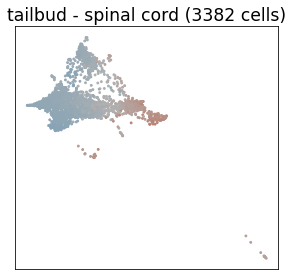

In [70]:
scprep.plot.scatter2d(curr_data_phate, 
                      c=curr_metadata['chd_likelihood'], 
                      cmap=meld.get_meld_cmap(), vmin=0, vmax=1,
                      ticks=False, figsize=(4,4),
                      title='{} ({} cells)'.format(curr_cluster, curr_data_phate.shape[0]), 
                      legend=False, fontsize=10)

This concludes the workshop version of the notebook, but to see how vertex frequency clustering interacts with MELD to identify subpopulations of cell, please consult [the full tutorial on GitHub](https://github.com/KrishnaswamyLab/MELD).